In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import Model, layers, optimizers
from tensorflow.keras.applications import VGG16
from sklearn.model_selection import train_test_split
import pandas as pd
import pathlib
from keras_tuner.tuners import RandomSearch


base_dir = './Dataset 2' 

In [2]:
data_dir = pathlib.Path('./Dataset 2')

all_images = list(data_dir.glob('*/*.jpg'))
all_labels = [p.parent.name for p in all_images]


train_files, rest_files, train_labels, rest_labels = train_test_split(all_images, all_labels,
                                                                    test_size=0.3,
                                                                    random_state=42)


validation_files, test_files, validation_labels, test_labels = train_test_split(rest_files, rest_labels,
                                                                               test_size=0.333,  # 0.333 dari rest (30%) = 0.1 total
                                                                               random_state=42)


In [3]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
)

validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [4]:
train_df = pd.DataFrame({'filename': [str(f) for f in train_files],
                         'class': train_labels})

validation_df = pd.DataFrame({'filename': [str(f) for f in validation_files],
                             'class': validation_labels})

test_df = pd.DataFrame({'filename': [str(f) for f in test_files],
                       'class': test_labels})

In [5]:
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col='filename',
    y_col='class',
    target_size=(224, 224),
    batch_size=16,
    class_mode='binary'
)

validation_generator = validation_datagen.flow_from_dataframe(
    validation_df,
    x_col='filename',
    y_col='class',
    target_size=(224, 224),
    batch_size=16,
    class_mode='binary',
    shuffle=False
)

test_generator = test_datagen.flow_from_dataframe(
    test_df,
    x_col='filename',
    y_col='class',
    target_size=(224, 224),
    batch_size=16,
    class_mode='binary',
    shuffle=False
)


Found 1706 validated image filenames belonging to 2 classes.
Found 488 validated image filenames belonging to 2 classes.
Found 244 validated image filenames belonging to 2 classes.


In [9]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from kerastuner.tuners import RandomSearch
from tensorflow.keras.models import Model

def build_model(hp):
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    
    for layer in base_model.layers:
        layer.trainable = False
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(hp.Int('units1', min_value=64, max_value=512, step=64), activation='relu')(x)
    x = Dropout(hp.Float('dropout1', 0.2, 0.5, step=0.1))(x)
    x = Dense(hp.Int('units2', min_value=32, max_value=256, step=32), activation='relu')(x)
    x = Dropout(hp.Float('dropout2', 0.2, 0.5, step=0.1))(x)
    output = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=base_model.input, outputs=output)
    model.compile(
        optimizer=Adam(learning_rate=hp.Choice('lr', [1e-2, 1e-3, 1e-4])),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model


tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=20,
    executions_per_trial=1,
    directory='kt_dir 2',
    project_name='pharyngitis_vgg16'
)

Reloading Tuner from kt_dir 2\pharyngitis_vgg16\tuner0.json


In [10]:

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

#tuner.search(train_generator, epochs=50, validation_data=validation_generator, callbacks=[stop_early])

In [11]:
best_model = tuner.get_best_models(num_models=1)[0]
best_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 448)            │       229,824 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 448)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       114,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 15,059,713 (57.45 MB)

 Trainable params: 345,025 (1.32 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [13]:
test_loss, test_acc = best_model.evaluate(test_generator)
print(f'Test Accuracy: {test_acc:.2f}')

c:\Users\izzam\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


16/16 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.7888 - loss: 0.3737
Test Accuracy: 0.80


In [14]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best hyperparameters:")
print(f" - units1: {best_hps.get('units1')}")
print(f" - units2: {best_hps.get('units2')}")
print(f" - dropout1: {best_hps.get('dropout1')}")
print(f" - dropout2: {best_hps.get('dropout2')}")
print(f" - Learning Rate: {best_hps.get('lr')}")

Best hyperparameters:
 - units1: 448
 - units2: 256
 - dropout1: 0.4
 - dropout2: 0.30000000000000004
 - Learning Rate: 0.0001


In [ ]:

best_model = tuner.hypermodel.build(best_hps)

for layer in best_model.layers:
    if layer.name.startswith('block5_') or layer.name.startswith('block4_'):
        layer.trainable = True
history = best_model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=50,
    batch_size=32,
    verbose=1
)

Epoch 1/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 280s 3s/step - accuracy: 0.6193 - loss: 0.6739 - val_accuracy: 0.5758 - val_loss: 0.6822
Epoch 2/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 274s 3s/step - accuracy: 0.5915 - loss: 0.6741 - val_accuracy: 0.5758 - val_loss: 0.6741
Epoch 3/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 271s 3s/step - accuracy: 0.5535 - loss: 0.6800 - val_accuracy: 0.7090 - val_loss: 0.5905
Epoch 4/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 273s 3s/step - accuracy: 0.7284 - loss: 0.5581 - val_accuracy: 0.7254 - val_loss: 0.5208
Epoch 5/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 276s 3s/step - accuracy: 0.8110 - loss: 0.4493 - val_accuracy: 0.7971 - val_loss: 0.4026
Epoch 6/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 278s 3s/step - accuracy: 0.8780 - loss: 0.3210 - val_accuracy: 0.8689 - val_loss: 0.3066
Epoch 7/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 292s 3s/step - accuracy: 0.8917 - loss: 0.2816 - val_accuracy: 0.8770 - val_loss: 0.2842
Epoch 8/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 301s 3s/step - accuracy: 0.9162 - loss: 0.2137 - val_accu

In [22]:
best_model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 448)            │       229,824 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 448)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 256)            │       114,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 41,708,165 (159.10 MB)

 Trainable params: 13,324,225 (50.83 MB)

 Non-trainable params: 1,735,488 (6.62 MB)

 Optimizer params: 26,648,452 (101.66 MB)

In [23]:
test_loss, test_acc = best_model.evaluate(test_generator)
print(f'Test Accuracy: {test_acc:.2f}')

16/16 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.9743 - loss: 0.0915
Test Accuracy: 0.97


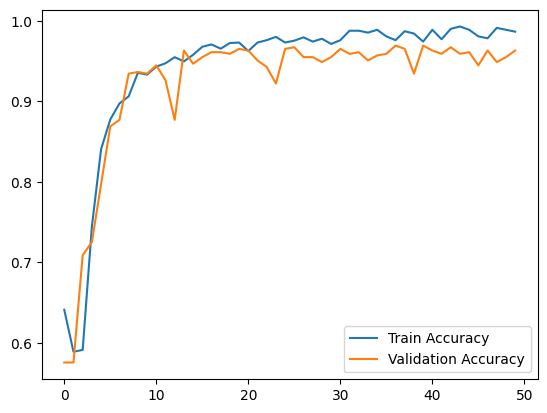

In [24]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()

16/16 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step
Evaluasi best_model hasil tuning:
              precision    recall  f1-score   support

  faringitis       0.98      0.95      0.97       108
      normal       0.96      0.99      0.97       136

    accuracy                           0.97       244
   macro avg       0.97      0.97      0.97       244
weighted avg       0.97      0.97      0.97       244



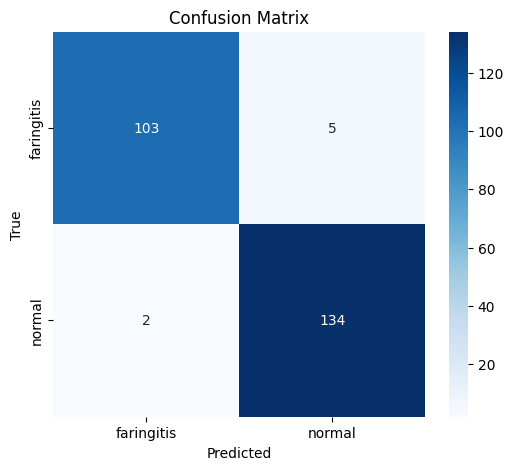

In [25]:
test_generator.reset()
Y_pred_best = best_model.predict(test_generator)
y_pred_best = (Y_pred_best > 0.5).astype(int).reshape(-1)

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

print("Evaluasi best_model hasil tuning:")
print(classification_report(test_generator.classes, y_pred_best, target_names=test_generator.class_indices.keys()))

cm = confusion_matrix(test_generator.classes, y_pred_best)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=test_generator.class_indices.keys(),
            yticklabels=test_generator.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
# best_model.save('tuner_vgg16_pharyngitis_model.keras')